<a href="https://colab.research.google.com/github/justprophet/Memorability-of-videos/blob/master/code/Memorability_with_Captions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Spearman Coefficient

In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

# Mounting the drive

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Semester 2/Machine Learning/Assignment/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!pip install pyprind

# Importing Libraries

In [0]:
import pandas as pd
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
# Import EarlyStopping
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import numpy as np
from string import punctuation
import pyprind
from collections import Counter
#from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Load Captions and Video Memorability from the two files

In [0]:
# load labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df


# load the captions
cap_path = './dev-set_video-captions.txt'
df_captions=read_caps(cap_path)

# load the ground truth values
label_path = './'
labels=pd.read_csv(label_path+'dev-set_ground-truth.csv')

Joining the dataframes.

In [0]:
df = df_captions.merge(labels,on=["video"],how="inner")
df

,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,blonde-woman-is-massaged-tilt-down,0.924,34,0.846,13
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot,0.923,33,0.667,12
2,video6.webm,khr-gangsters,0.863,33,0.700,10
3,video8.webm,medical-helicopter-hovers-at-airport,0.922,33,0.818,11
4,video10.webm,couple-relaxing-on-picnic-crane-shot,0.950,34,0.900,10
5,video12.webm,passing-by-older-man-reading,0.783,74,0.750,12
6,video13.webm,christmas-village-and-national-christmas-tree,0.861,40,0.700,10
7,video16.webm,unhappy-friends-looking-for-something-interest...,0.834,33,0.857,14
8,video17.webm,hoover-dam-tourists-traffic,0.777,43,1.000,11
9,video18.webm,happy-girl-stretching-and-relaxing-on-the-station,0.863,33,1.000,9


#Using Count Vecorizer

In [0]:
cv=CountVectorizer()

In [0]:
X_CV=cv.fit_transform(df['caption'])

In [0]:
X_arrseq=X_CV.toarray()
X_arrseq

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [0]:
print(X_arrseq[0])

[0 0 0 ... 0 0 0]


# Splitting the Data in Train and Test

In [0]:
Y=df[['short-term_memorability','long-term_memorability']].values  #targets
X=X_arrseq #input

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # random state for reproducability

In [0]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 5174)
X_test (1200, 5174)
Y_train (4800, 2)
Y_test (1200, 2)


# Construction of Neural Networks

In [0]:
n_cols = X_train.shape[1]
n_cols

5174

In [0]:
# Save the number of columns in predictors: n_cols


# Set up the model: model
model = Sequential()

In [0]:
# Add the first layer
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Add the second layer
model.add(Dense(100, activation='relu'))

In [0]:
# Add the output layer
model.add(Dense(2))

#Changing optimization parameters

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
   
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)
    
# Fit the model
#model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))
# Fit the model
history=model.fit(X_train, Y_train, validation_split=0.3, epochs=30, callbacks= [early_stopping_monitor])

Instructions for updating:
Use tf.cast instead.
Train on 3360 samples, validate on 1440 samples
Epoch 1/30
3360/3360 [==============================] - 1s 432us/step - loss: 0.1257 - acc: 0.5842 - val_loss: 0.0216 - val_acc: 0.6750
Epoch 2/30
3360/3360 [==============================] - 1s 384us/step - loss: 0.0160 - acc: 0.7158 - val_loss: 0.0186 - val_acc: 0.6493
Epoch 3/30
3360/3360 [==============================] - 1s 375us/step - loss: 0.0087 - acc: 0.7685 - val_loss: 0.0184 - val_acc: 0.6833
Epoch 4/30
3360/3360 [==============================] - 1s 372us/step - loss: 0.0062 - acc: 0.8071 - val_loss: 0.0185 - val_acc: 0.6778
Epoch 5/30
3360/3360 [==============================] - 1s 370us/step - loss: 0.0050 - acc: 0.8360 - val_loss: 0.0190 - val_acc: 0.6542


In [0]:
# Compile the model
#model.compile(optimizer='adam', loss = 'mean_squared_error')

In [0]:
# Verify that model contains information from compiling
#print("Loss function: " + model.loss)

In [0]:
# Fit the model
#history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

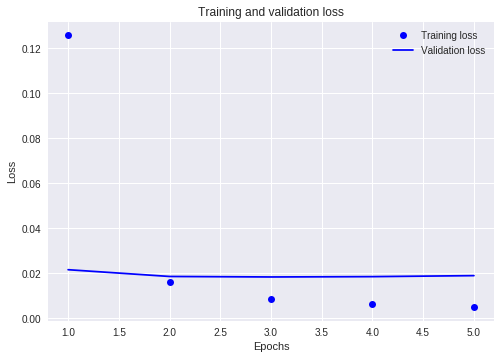

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
predictions = model.predict(X_test)
print(predictions)
Get_score(predictions, Y_test) # Try remember what the Spearman scores actually mean!


[[0.8799533  0.7568781 ]
 [1.0280266  0.9772646 ]
 [0.8758796  0.7280882 ]
 ...
 [0.96437544 0.9807859 ]
 [0.8173879  0.7274594 ]
 [0.7923419  0.61887515]]
The Spearman's correlation coefficient is: 0.319
The Spearman's correlation coefficient is: 0.122




# Using TFIDF Algorithm

In [0]:
tfidf=TfidfVectorizer(min_df=1, stop_words='english')

In [0]:
X_TF=tfidf.fit_transform(df['caption'])

In [0]:
X_tfarrseq=X_TF.toarray()
X_tfarrseq

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
print(X_tfarrseq[0])

[0. 0. 0. ... 0. 0. 0.]


In [0]:
Y=df[['short-term_memorability','long-term_memorability']].values  #targets
X=X_tfarrseq #input

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # random state for reproducability

In [0]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 5019)
X_test (1200, 5019)
Y_train (4800, 2)
Y_test (1200, 2)


In [0]:
n_cols = X_train.shape[1]
n_cols

5019

In [0]:
# Save the number of columns in predictors: n_cols


# Set up the model: model
model = Sequential()
# Add the first layer
model.add(Dense(50, activation='relu', input_shape=(n_cols,)))
# Add the second layer
model.add(Dense(32, activation='relu'))
# Add the output layer
model.add(Dense(2))

In [0]:
# Compile the model
model.compile(optimizer='adam', loss = 'mean_squared_error')

In [0]:
# Verify that model contains information from compiling
print("Loss function: " + model.loss)

Loss function: mean_squared_error


In [0]:
# Fit the model
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 1s 282us/step - loss: 0.1353 - val_loss: 0.0170
Epoch 2/20
4800/4800 [==============================] - 1s 228us/step - loss: 0.0118 - val_loss: 0.0158
Epoch 3/20
4800/4800 [==============================] - 1s 228us/step - loss: 0.0086 - val_loss: 0.0165
Epoch 4/20
4800/4800 [==============================] - 1s 231us/step - loss: 0.0073 - val_loss: 0.0175
Epoch 5/20
4800/4800 [==============================] - 1s 227us/step - loss: 0.0065 - val_loss: 0.0181
Epoch 6/20
4800/4800 [==============================] - 1s 224us/step - loss: 0.0061 - val_loss: 0.0182
Epoch 7/20
4800/4800 [==============================] - 1s 232us/step - loss: 0.0056 - val_loss: 0.0190
Epoch 8/20
4800/4800 [==============================] - 1s 222us/step - loss: 0.0052 - val_loss: 0.0187
Epoch 9/20
4800/4800 [==============================] - 1s 211us/step - loss: 0.0049 - val_loss: 0.0196
Epoch 10/20
4800

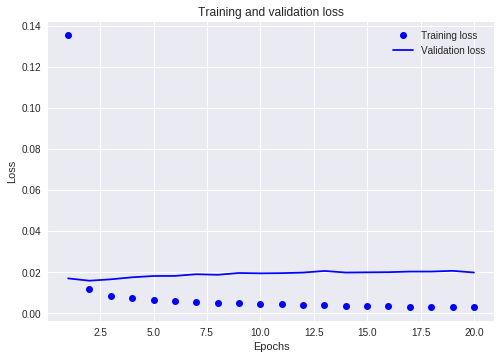

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
predictions = model.predict(X_test)
print(predictions)
Get_score(predictions, Y_test) # Try remember what the Spearman scores actually mean!

[[0.9135992  0.76794326]
 [0.97705674 0.86528105]
 [0.911112   0.87680054]
 ...
 [1.0521218  1.1392775 ]
 [0.8278694  0.69183505]
 [0.87327343 0.70102036]]
The Spearman's correlation coefficient is: 0.309
The Spearman's correlation coefficient is: 0.152
